# Kuzushiji MNIST
<hr>


## Background

Recorded historical documents give us a peek into the past. We are able to glimpse the world before our time; and see its culture, norms, and values to reflect on our own. Japan has very unique historical pathway. Historically, Japan and its culture was relatively isolated from the West, until the Meiji restoration in 1868 where Japanese leaders reformed its education system to modernize its culture. This caused drastic changes in the Japanese language, writing and printing systems. Due to the modernization of Japanese language in this era, cursive __Kuzushiji__ (くずし字) script is no longer taught in the official school curriculum. Even though Kuzushiji had been used for over 1000 years, most Japanese natives today cannot read books written or published over 150 years ago.

<br>

The result is that there are hundreds of thousands of Kuzushiji texts that have been digitised but have never been transcribed, and can only currently be read by a few experts. We've built Kuzushiji-MNIST and sister datasets by taking handwritten characters from these texts and preprocessing them in a format similar to the MNIST dataset, to create easy to use benchmark datasets that are more modern and difficult to classify than the original MNIST dataset.

<br>

## Data sets

There are several given data:

1. __Kuzushiji-MNIST__ is a drop-in replacement for the MNIST data set, provided in the original MNIST format as well as NumPy format. Since MNIST restricts us to 10 classes, we choose one character to represent each of the 10 rows of Hiragana when creating Kuzushiji-MNIST.

   - `kminst-[train/test]-[images/labels].npz`: These files contain the Kuzushiji-MNIST as compressed numpy arrays, and can be read with `arr = np.load(filename)['arr_0']`. 
   - `[train/t10k]-[images/labels]-idx[1/3]-ubyte.gz`: These files contain Kuzushiji-MNIST with the same file format and filenames as the original MNIST for drop-in compatibility.
   - `kmnist-classmap.csv`: A mapping from class IDs to unicode charachters for Kuzushiji-MNIST.

2. __Kuzushiji-49__ has 49 classes (28x28 grayscale, 270,912 images) is a much larger but imbalanced data set containing 48 Hiragana characters and one Hiragana iteration mark.

   - `k49-[train/test]-[images/labels].npz`: containing Kuzushiji-49 as compressed numpy arrays
   - `k49-classmap.csv`: mapping from class IDs to unicode characters for Kuzushiji-49.

3. __Kuzushiki-Kanji__ is an imbalanced data set of total 3,832 Kanji characters (64x64 grayscale, 140,426 images), ranging from 1,766 examples to only a _single_ example per class.

   - `kkanji2/` folder contains subfolders of images, with each subfolder corresponding to one Kanji character class.
   
## License
The dataset is licensed under a permissive CC BY-SA 4.0 license, which requires attribution, and we would suggest to use the following attribution to the KMNIST dataset:

"KMNIST Dataset" (created by CODH), adapted from "Kuzushiji Dataset" (created by NIJL and others), doi:10.20676/00000341

<br>

Reference to [GitHub](https://github.com/rois-codh/kmnist)

In [1]:
import os, gc
import pandas as pd
import numpy as np
# Viz
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
plt.style.use('fivethirtyeight')
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\n.satsawat\Anaconda3_\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



There are a lot of files with different purposes to work with.

In [2]:
os.listdir('../data')

['k49-test-imgs.npz',
 'k49-test-labels.npz',
 'k49-train-imgs.npz',
 'k49-train-labels.npz',
 'k49_classmap.csv',
 'kkanji.tar',
 'kmnist-test-imgs.npz',
 'kmnist-test-labels.npz',
 'kmnist-train-imgs.npz',
 'kmnist-train-labels.npz',
 'kmnist_classmap.csv',
 't10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'train-labels-idx1-ubyte.gz']

In [3]:
SEED = 515
def get_missing_values(df, 
                       return_missing_df_flag=False):
    '''
    Function to explore how many missing values (NaN) in the pandas
    @Args:
       df: pandas dataframe
       return_missing_df_flag: The boolean flag to return the missing pandas or not
       
    Return:
       Depends on the boolean flag; it will return the missing data table
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print("There are %s columns that have missing values" % str(mis_val_table_ren_columns.shape[0]))
    if return_missing_df_flag:
        return mis_val_table_ren_columns

### Section 1: Kuzushiji MNIST

Because we are given __three__ different data sets for Kuzushiji with different objectives, in this section I will aim for the basic KMNIST, which is the new version of MNIST.

Before going there, let's first examine their definitions. MNIST ("Modified National Institute of Standards and Technology") is the de facto "hello world" data set of computer vision. KMNIST (Kuzushiji-MNIST) was introduced as an alternative to MNIST. It contains images with the first entries from the 10 main Japanese Hiragana characters.

In [4]:
kmnist_train_image = np.load('../data/kmnist-train-imgs.npz')['arr_0']
kmnist_train_label = np.load('../data/kmnist-train-labels.npz')['arr_0']

kmnist_test_image = np.load('../data/kmnist-test-imgs.npz')['arr_0']
kmnist_test_label = np.load('../data/kmnist-test-labels.npz')['arr_0']

#### Data Understanding and Visualization

We have data of 60k as training data set with 10k testing data set. All images have 28x28 pixel.

In [5]:
print(f'KMNIST train image shape of %s with data types of %s' \
      % (kmnist_train_image.shape, type(kmnist_train_image)))

print(f'KMNIST train labels shape of %s with data types of %s' \
      % (kmnist_train_label.shape, type(kmnist_train_label)))

print(f'KMNIST test image shape of %s with data types of %s' \
      % (kmnist_test_image.shape, type(kmnist_test_image)))

print(f'KMNIST test labels shape of %s with data types of %s' \
      % (kmnist_test_label.shape, type(kmnist_test_label)))

KMNIST train image shape of (60000, 28, 28) with data types of <class 'numpy.ndarray'>
KMNIST train labels shape of (60000,) with data types of <class 'numpy.ndarray'>
KMNIST test image shape of (10000, 28, 28) with data types of <class 'numpy.ndarray'>
KMNIST test labels shape of (10000,) with data types of <class 'numpy.ndarray'>


In [6]:
char_map_df = pd.read_csv('../data/kmnist_classmap.csv', encoding='utf-8')
display(char_map_df.head(3))
display(char_map_df.tail(3))
print(f'The character mapping: %s %s' % (char_map_df.shape, type(char_map_df)))

index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す

index codepoint char
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を

The character mapping: (10, 3) <class 'pandas.core.frame.DataFrame'>


The labels are distributed equally (10% for each class).

In [7]:
def plot_count_numpy(array: np.ndarray, plot_name: str=''):
    '''
    TODO: Add function comment
    '''
    data_ = array
    hist_ = np.histogram(data_)
    binsize_ = hist_[1][1] - hist_[1][0]
    
    _trace = go.Histogram(x=data_,
                          name='count',
                          marker=dict(color='white')
                         )
    
    layout = go.Layout(title=dict(text=plot_name, 
                                  font=dict(family='Helvetica',
                                            size=28,
                                            color='white'
                                           )
                                 ),
                       bargap=.2,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       autosize=False,
                       width=600,
                       height=400,
                       xaxis=dict(color='gray', showgrid=False),
                       yaxis=dict(color='gray', showgrid=False)
                      )
    trace_data = [_trace]
    fig = go.Figure(data=trace_data, layout=layout)
    py.iplot(fig)

    
plot_count_numpy(kmnist_train_label, plot_name = '<b>Train</b> Label Distribution')

This also holds true for testing data labels.

In [8]:
plot_count_numpy(kmnist_test_label, plot_name = '<b>Test</b> Label Distribution')

Now let us explore the actual images of the __KMNIST__.

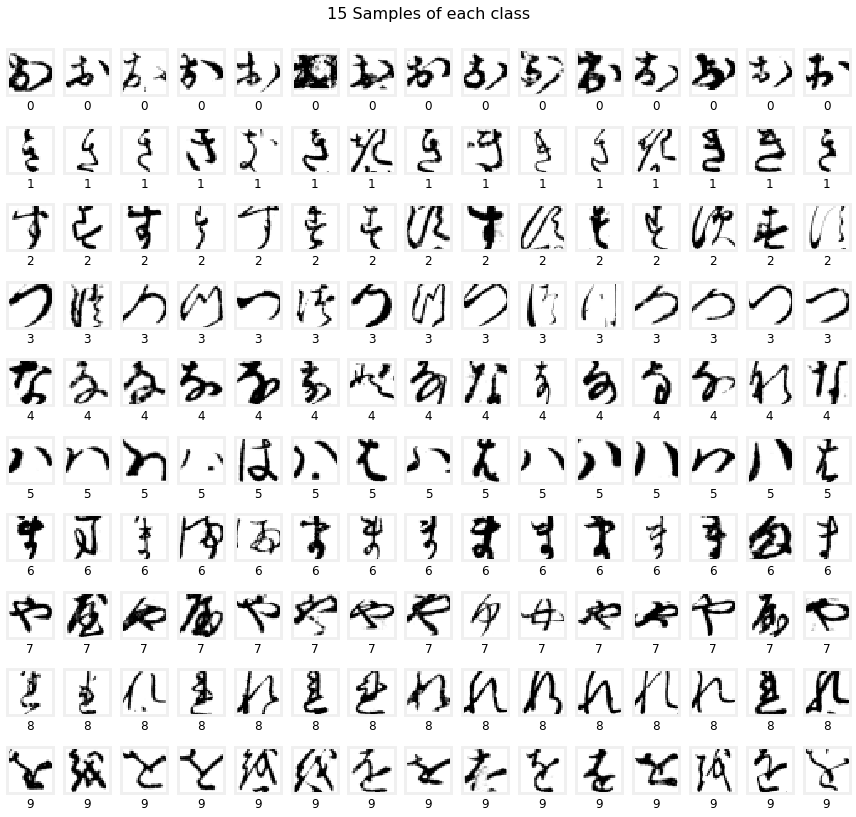

In [9]:
def plot_kmnist_image(images: np.ndarray, labels: np.ndarray, 
                      n_sample: int=10):
    '''
    Function to plot the sample Kuzushiji-MNIST image for each class
    Parameters:
      images (np.ndarray): a numpy array consists of KMNIST data (28x28 pixels)
      labels (np.ndarray): a numpy array consists of KMNIST target label
      n_samples (int): how many samples per class will it be plotted; default: 10
    
    Returns:
      None: only matplotlib figure will be shown on console
    '''
    from tqdm import tqdm_notebook
    
    fig = plt.figure(figsize=(12, 12))
    i_ = len(np.unique(labels))
    for i in tqdm_notebook(range(i_)):
        _imgs = images[np.where(labels == i)]
        _labs = labels[np.where(labels == i)]
        for j in range(n_sample):
            plt.subplot(i_, n_sample, i*n_sample + j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(_imgs[j], cmap=plt.cm.binary)
            plt.xlabel(_labs[j])
            #plt.xlabel(u'%s' % char_map_df.loc[char_map_df.index == i, 'codepoint'].values.tolist())
    
    fig.subplots_adjust(top=2)  # add this to handle tight_layout() method
    fig.suptitle('%s Samples of each class' % n_sample, fontsize=16)
    plt.tight_layout()
    plt.show()


plot_kmnist_image(kmnist_train_image, kmnist_train_label, n_sample=15)

Let's quickly peak into the testing images.

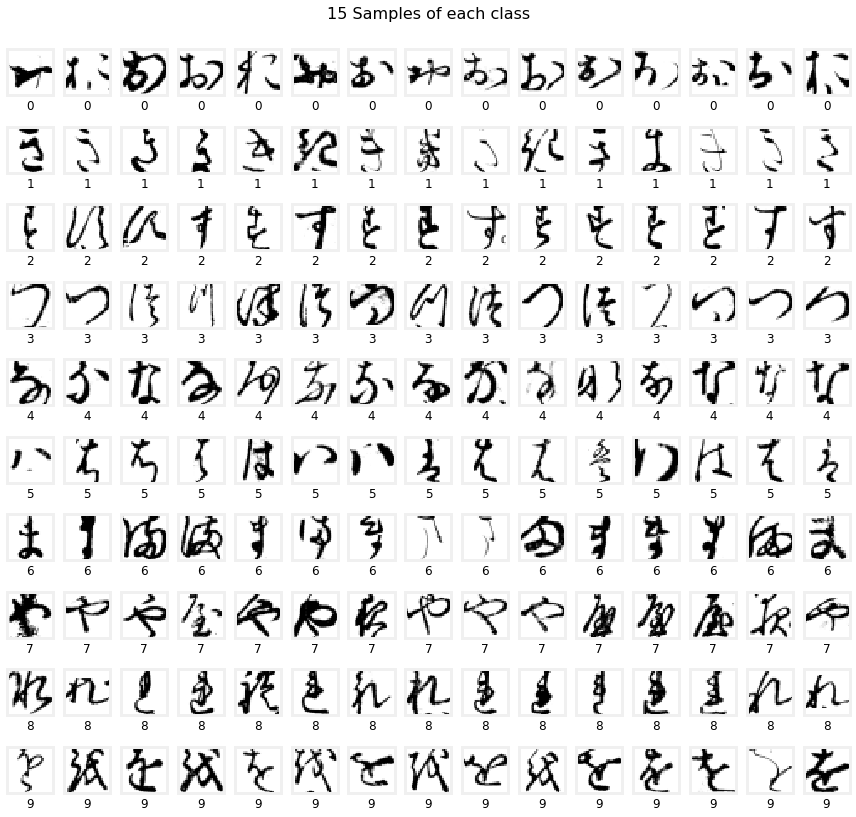

In [10]:
plot_kmnist_image(kmnist_test_image, kmnist_test_label, n_sample=15)

<hr>

There are total of 60k training images and each image is all 28-by-28 pixel images, therefore, it has a total of 784 __features or dimensions__. Each component contains a value between 0 and 1, which describes the intensity of each pixel. This data set is quite large and can be the basic of dimensionality reduction method.

#### Dimensionality reduction

Given the images are displayed and can be treat as high-dimension, I will demonstrate some techniques to reduce the number of dimensions in a data set.

- __PCA__ (Principal Component Analysis): It is using the correlation between some dimensions and tries to provide a _minimum number of variables_ that keeps the _maximum amount of variation or information_ about how the original data is distributed.
- __t-SNE__ (t-Distributed Stochastic Neighbor Embedding): this is contrary to PCA, it is not a mathematical technique but a probablistic one. t-SNE minimizes the divergence between two distributions: a distribution that _measures pairwise similarities of the corresponding low-dimensional points_ in the embedding. Due to its heavy computational, it is highly recommend to use another dimensionality reduction method (i.e. PCA for dense data, or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount if the number of features is very high.
- __UMAP__ (Uniform Manifold Approximation and Projection): can be used for visualization similarly to t-SNE, but also for __general non-linear dimension reduction__.

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap

__Section 1: PCA__

PCA is a linear transformation algorithm that seeks to project the original features of our data onto a smaller set of features (or sub-space) while retaining most of the information. 

Check out this [great explanation](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579) by amoeba at stackexchange.

___Calculating the Eigenvectors___

Every eigenvector has a corresponding eigenvalue. 

- An eigenvector is a direction of the line (vertical, 45 degree etc).
- An eigenvalue is a number, telling how much variance there is in the data in that direction.
- The eigenvector with the highest eigenvalue is therefore the principal component.

__Note__:

Whether to standardize the data prior to PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that __maximizes the variance along the axes__, it makes more sense to standardize the data, especially, if it was measured on different scales.

$z = \frac{(x - \bar x)}{SD}$  


In [12]:
def reshape_3d_to_2d(data_array: np.ndarray) -> np.ndarray:
    """
    Function to convert 3d numpy array to 2d numpy array
    @Arg:
      data_array: the numpy array, we want to convert
      
    Return:
      The converted numpy array
    """
    out_array = data_array.reshape(data_array.shape[0], 
                                   data_array.shape[1] * data_array.shape[2])
    return out_array


def compute_variance(kmnist_img: np.ndarray) -> (list, np.ndarray):
    """
    Function to compute the individual and cumulative variance explained 
    @Args:
      kmnist_img: the numpy array contains the MNIST data
      
    Return:
      Individual and cumulative explained variances
    """
    _img = kmnist_img.astype(np.float32)
    if len(_img.shape) == 3:
        _img = reshape_3d_to_2d(_img)
    
    _img_scale = StandardScaler().fit_transform(_img)
    # compute mean and conv matrix for eigenvalue, eigenvector
    mean_vec = np.mean(_img_scale, axis=0)
    conv_mat = np.cov(_img_scale.T)
    eig_vals, eig_vecs = np.linalg.eig(conv_mat)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)  # sort the eigenvalue, eigenvector pairs from high to low
    total_ = sum(eig_vals)
    ind_var_exp_ = [(i/total_)*100 for i in sorted(eig_vals, reverse=True)]  
    cum_var_exp_ = np.cumsum(ind_var_exp_)
    return ind_var_exp_, cum_var_exp_


def plot_variance_explain(ind_var_exp: list, cum_var_exp: list,
                          n_dimension: int=786, variance_limit: int=50
                         ):
    """
    Function to plot the individual and cumulative explained variances 
      with zoom into specific limit numbers
    @Args:
      ind_var_exp:
      cum_var_exp:
      n_dimension:
      variance_limit:
      
    Return:
      No object returned, only visualization on console / notebook
    """
    # Trace 1 and 2 will act as partial plot, whereas 3 and 4 will be full plot
    trace1 = go.Scatter(x=list(range(n_dimension)),
                        y=cum_var_exp,
                        mode='lines+markers',
                        name='Cumulative Explained Variance (Partial)',
                        hoverinfo='x+y',
                        line=dict(shape='linear',
                                  color='red'
                                 )
                       )
    
    trace2 = go.Scatter(x=list(range(n_dimension)),
                        y=ind_var_exp,
                        mode='lines+markers',
                        name='Individual Explained Variance (Partial)',
                        hoverinfo='x+y',
                        line=dict(shape='linear',
                                  color='white'
                                 )
                       )

    trace3 = go.Scatter(x=list(range(n_dimension)),
                        y=cum_var_exp,
                        mode='lines+markers',
                        name='Cumulative Explained Variance (Full)',
                        hoverinfo='x+y',
                        line=dict(shape='linear',
                                  color='blue'
                                 )
                       )
    
    trace4 = go.Scatter(x=list(range(n_dimension)),
                        y=ind_var_exp,
                        mode='lines+markers',
                        name='Individual Explained Variance (Full)',
                        hoverinfo='x+y',
                        line=dict(shape='linear',
                                  color='gray'
                                 )
                       )

    fig = tls.make_subplots(rows=2, cols=1, print_grid=False)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 1)
    fig['layout']['xaxis1'].update(range=[0, variance_limit], color='gray', showgrid=False)
    fig['layout']['yaxis1'].update(range=[0, 90], color='gray', showgrid=False)
    fig['layout']['xaxis2'].update(color='gray', showgrid=False)
    fig['layout']['yaxis2'].update(color='gray', showgrid=False)
    fig['layout'].update(title=dict(text='<b>Variances Explained</b> (zoom to %s variances)' % 
                                    variance_limit,
                                    font=dict(size=20, color='white')
                                   ), 
                         height=600, width=850, 
                         showlegend=True, paper_bgcolor='#000', plot_bgcolor='#000',
                         autosize=False,
                         legend=dict(traceorder='normal',
                                     font=dict(size=12,
                                               color='white'
                                              )
                                    )
                         )
    py.iplot(fig)
    

ind_var_exp, cum_var_exp = compute_variance(kmnist_train_image)

Now we have both individual and cumulative explained variances, we can plot them interactively using `plotly` library. This plot uses to answer the question like "how many principal components are we going to choose for our new feature subspace?".

<br>

The explained variance tells us how much information (variance) can be attributed to each of the principal components.

<br>

The plot below clearly shows how each principal component can use to explain the variance (information).

From the plot, we can see that out of all 784 features, 

- 75% of the explained variance can be described by using 76 features.
- 80% of the explained variance can be described by using 97 features.
- 90% of the explained variance can be described by using 175 features.


In [13]:
plot_variance_explain(ind_var_exp, cum_var_exp, variance_limit=80)

Now let's use the __PCA__ from sklearn. Since PCA method seeks to obtain the optimal directions that captures the most variance (spreads out the data points the most).

In [14]:
N_COMPONENTS = 35
def preprocessing_pca(data_array: np.ndarray):
    out_array = data_array.astype(np.float32)
    out_array = reshape_3d_to_2d(out_array)
    out_array = StandardScaler().fit_transform(out_array)   # Z-normalization
    return out_array

transform_train_img = preprocessing_pca(kmnist_train_image)
pca = PCA(n_components=N_COMPONENTS, random_state=SEED)
pca.fit(transform_train_img)
pca_eigenvalues_ = pca.components_.reshape(N_COMPONENTS, 
                                           kmnist_train_image.shape[1], 
                                           kmnist_train_image.shape[2])

We can then visualize the PCA components, in this case I have selected 35 components from PCA.

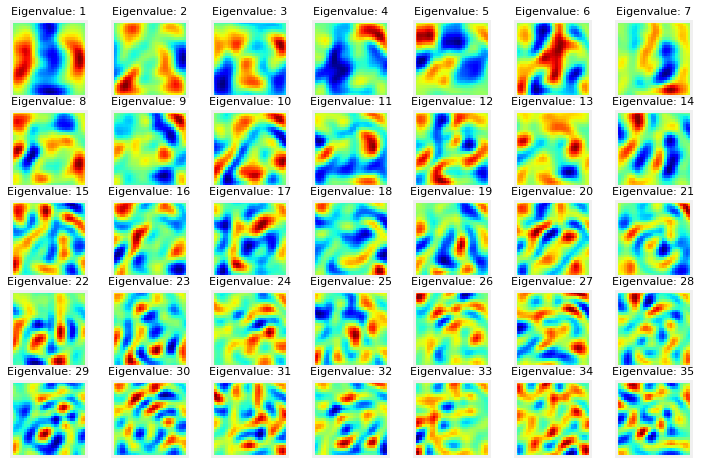

In [15]:
def plot_pca_eigenvalue(pca_eigenval: np.ndarray,
                        nrow:int = 5, ncol:int = 7
                       ):
    
    plt.figure(figsize=(11, 8))
    for i in list(range(nrow * ncol)):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(pca_eigenval[i], cmap='jet')
        plt.title('Eigenvalue: %s' % str(i+1), size=11)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
plot_pca_eigenvalue(pca_eigenvalues_)

Can only 2 or 3 principal components separate our Kuzushiji MNIST? To save memory and interaction, I will only display the first 2000 data points from training data set.

In [16]:
def plot_2d_pca(img_array: np.ndarray, img_label: np.ndarray, 
                top_n: int=2000, mapping_df: pd.DataFrame=char_map_df):
    pca = PCA(n_components=2, random_state=SEED)
    pca.fit(img_array)
    _x = pca.transform(img_array)[: top_n]
    _target_idx = img_label[: top_n]
    _target_char = []
    for i in img_label[: top_n]:
        _target_char.append(mapping_df.loc[mapping_df.index == i, 'char'].values[0])
        
    _target_char = np.array(_target_char)
    _hover_text = []
    for i in range(len(_target_char)):
        _txt = 'Class %s (or index %s)' % (_target_char[i], _target_idx[i])
        _hover_text.append(_txt)
        
    trace0 = go.Scatter(x=_x[:, 0],
                        y=_x[:, 1],
                        text=_hover_text,
                        hoverinfo='text+x+y',
                        mode='markers',
                        showlegend=False,
                        marker=dict(size=7,
                                    color=_target_idx,
                                    colorscale='Jet',
                                    showscale=False,
                                    line=dict(width=2,
                                              color='rgb(255, 255, 255)'
                                             ),
                                    opacity=.6
                                   )
                       )
    data = [trace0]
    layout = go.Layout(title=dict(text='<b>2D</b> Principal Component Analysis',
                                  font=dict(size=24, color='white')
                                 ),
                       hovermode='closest',
                       autosize=False,
                       width=800,
                       height=600,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       xaxis=dict(title='PC1 (%.2f%%)' % \
                                    (pca.explained_variance_ratio_[0]*100),
                                  zeroline=True,
                                  showgrid=False,
                                  color='gray'
                                 ),
                       yaxis=dict(title='PC2 (%.2f%%)' % \
                                    (pca.explained_variance_ratio_[1]*100),
                                  zeroline=True,
                                  showgrid=False,
                                  color='gray'
                                 )
                      )
                       
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

    
plot_2d_pca(transform_train_img, kmnist_train_label)

In [17]:
def plot_3d_pca(img_array: np.ndarray, img_label: np.ndarray, 
                top_n: int=2000, mapping_df: pd.DataFrame=char_map_df):
    pca = PCA(n_components=3, random_state=SEED)
    pca.fit(img_array)
    _x = pca.transform(img_array)[: top_n]
    _target_idx = img_label[: top_n]
    _target_char = []
    for i in img_label[: top_n]:
        _target_char.append(mapping_df.loc[mapping_df.index == i, 'char'].values[0])
        
    _target_char = np.array(_target_char)
    _hover_text = []
    for i in range(len(_target_char)):
        _txt = 'Class %s (or index %s)' % (_target_char[i], _target_idx[i])
        _hover_text.append(_txt)
        
    trace0 = go.Scatter3d(x=_x[:, 0],
                        y=_x[:, 1],
                        z=_x[:, 2],
                        text=_hover_text,
                        hoverinfo='text+x+y+z',
                        mode='markers',
                        showlegend=False,
                        marker=dict(size=4,
                                    color=_target_idx,
                                    colorscale='Jet',
                                    showscale=False,
                                    line=dict(width=2,
                                              color='rgba(217, 217, 217, 0.14)'
                                             ),
                                    opacity=.7
                                   )
                       )
    data = [trace0]
    layout = go.Layout(title=dict(text='<b>3D</b> Principal Component Analysis',
                                  font=dict(size=24, color='white')
                                 ),
                       hovermode='closest',
                       autosize=False,
                       width=800,
                       height=600,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       margin=dict(l=0, r=0, b=0, t=60),
                       scene=dict(aspectratio=dict(x=1, y=1, z=1),
                                  camera=dict(center=dict(x=0, y=0, z=0),
                                              up=dict(x=0, y=0, z=20)
                                             ),
                                  dragmode='turntable',
                                  xaxis=dict(title='PC1 (%.2f%%)' % \
                                               (pca.explained_variance_ratio_[0]*100),
                                             color='gray',
                                             showgrid=False
                                            ),
                                  yaxis=dict(title='PC2 (%.2f%%)' % \
                                               (pca.explained_variance_ratio_[1]*100),
                                             color='gray',
                                             showgrid=False
                                            ),
                                  zaxis=dict(title='PC3 (%.2f%%)' % \
                                               (pca.explained_variance_ratio_[2]*100),
                                             color='gray',
                                             showgrid=False
                                            )
                                 )
                      )
                       
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    return pca, _x

    
pca_, X_pca = plot_3d_pca(transform_train_img, kmnist_train_label, top_n=5000)

How each principal component correlates with the input data? 

In [18]:
_tmp_pca = pd.DataFrame(data=X_pca,
                        index=np.arange(X_pca.shape[0]),
                        columns=['PCA_' + str(x+1) for x in np.arange(X_pca.shape[1])]
                       )

_tmp = pd.DataFrame(data=transform_train_img[:5000, :],
                    index=np.arange(transform_train_img[: 5000,:].shape[0]),
                    columns=['pixel_' + str(x+1) for x in np.arange(transform_train_img.shape[1])])

_tmp_full = pd.concat([_tmp, _tmp_pca], axis=1)

In [19]:
pca_corr = _tmp_full.corr()
keep_pca_corr = pca_corr.loc[~pca_corr.index.isin(['PCA_1', 'PCA_2', 'PCA_3']), 
                             ['PCA_1', 'PCA_2', 'PCA_3']]

In [20]:
trace = go.Heatmap(x=keep_pca_corr.columns,
                   y=keep_pca_corr.index,
                   z=keep_pca_corr,
                   name='Correlation',
                   colorscale='Jet'
                  )
layout = go.Layout(title=dict(text='Correlation between PC and normalized input pixel',
                              font=dict(size=20, color='white')),
                   hovermode='closest',
                   autosize=False,
                   width=700,
                   height=800,
                   paper_bgcolor='#000',
                   plot_bgcolor='#000',
                   xaxis=dict(title='Principal component',
                              zeroline=False,
                              showgrid=False,
                              color='gray'
                             ),
                   yaxis=dict(title='',
                              zeroline=False,
                              showgrid=False,
                              color='gray'
                             )
                  )

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

__Summary__:

- From the 2d and 3d plot, we can quickly see a few discernible clusters. These clusters represent the underlying each kuzushiji character that each data point contribute to.
- However, PCA algorithm is __unsupervised learning__ method which does not depend or learn on class labels. The color and hover text is added for presentation only.

__Section 2: LDA__

- Linear Discriminant Analysis (LDA), similar to PCA, is a linear transformation method commonly used in dimensionality reduction tasks.
- LDA is __supervised learning__ methods, as such the goal of LDA is that with the available information of the class labels, it will seek to maximize the separation between the different classes by computing the component axes (linear discriminants) which does this.
- For this demonstration, I will use the default setting of LDA model. The __n_components__ will automatically assign to either _min(n_classes)_ or _n_features_.

In [21]:
def plot_2d_lda(transform_array: np.ndarray, img_label: np.ndarray,
                n_components: int=None, top_n: int=2000, mapping_df: pd.DataFrame=char_map_df):
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    _x_lda = lda.fit_transform(transform_array, img_label)
    _x_lda = _x_lda[: top_n, :]
    _target_idx = img_label[: top_n]
    _target_char = []
    for i in img_label[: top_n]:
        _target_char.append(mapping_df.loc[mapping_df.index == i, 'char'].values[0])
        
    _target_char = np.array(_target_char)
    _hover_text = []
    for i in range(len(_target_char)):
        _txt = 'Class %s (or index %s)' % (_target_char[i], _target_idx[i])
        _hover_text.append(_txt)
    
    trace = go.Scatter(x=_x_lda[:, 0],
                       y=_x_lda[:, 1],
                       text=_hover_text,
                       hoverinfo='text+x+y',
                       mode='markers',
                       showlegend=False,
                       marker=dict(size=7,
                                   color=_target_idx,
                                   colorscale='Jet',
                                   showscale=False,
                                   line=dict(width=2,
                                             color='rgb(255, 255, 255)'),
                                   opacity=.6
                                  )
                      )
    data = [trace]
    layout = go.Layout(title=dict(text='<b>LDA</b> (Linear Discriminant Analysis): 2D plot',
                                  font=dict(size=24, color='white')
                                 ),
                       hovermode='closest',
                       autosize=False,
                       width=700,
                       height=500,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       xaxis=dict(title='',
                                  zeroline=True,
                                  showgrid=False,
                                  color='gray'
                                 ),
                       yaxis=dict(title='',
                                  zeroline=True,
                                  showgrid=False,
                                  color='gray'
                                 )
                      )
                       
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)    
    return lda, _x_lda


_ = plot_2d_lda(transform_train_img, kmnist_train_label, n_components=2, top_n=2000)

In [22]:
def plot_3d_lda(transform_array: np.ndarray, img_label: np.ndarray, 
                n_components: int=3, top_n: int=2000, mapping_df: pd.DataFrame=char_map_df):
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    _x_lda = lda.fit_transform(transform_array, img_label)
    _x_lda = _x_lda[: top_n, :]
    _target_idx = img_label[: top_n]
    _target_char = []
    for i in img_label[: top_n]:
        _target_char.append(mapping_df.loc[mapping_df.index == i, 'char'].values[0])
        
    _target_char = np.array(_target_char)
    _hover_text = []
    for i in range(len(_target_char)):
        _txt = 'Class %s (or index %s)' % (_target_char[i], _target_idx[i])
        _hover_text.append(_txt)
        
    trace0 = go.Scatter3d(x=_x_lda[:, 0],
                          y=_x_lda[:, 1],
                          z=_x_lda[:, 2],
                          text=_hover_text,
                          hoverinfo='text+x+y+z',
                          mode='markers',
                          showlegend=False,
                          marker=dict(size=4,
                                      color=_target_idx,
                                      colorscale='Jet',
                                      showscale=False,
                                      line=dict(width=2,
                                                color='rgba(217, 217, 217, 0.14)'
                                               ),
                                      opacity=.7
                                     )
                          )
    data = [trace0]
    layout = go.Layout(title=dict(text='<b>LDA</b> (Linear Discriminant Analysis): 3D plot',
                                  font=dict(size=24, color='white')
                                 ),
                       hovermode='closest',
                       autosize=False,
                       width=800,
                       height=600,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       margin=dict(l=0, r=0, b=0, t=60),
                       scene=dict(aspectratio=dict(x=1, y=1, z=1),
                                  camera=dict(center=dict(x=0, y=0, z=0),
                                              up=dict(x=0, y=0, z=20)
                                             ),
                                  dragmode='turntable',
                                  xaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            ),
                                  yaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            ),
                                  zaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            )
                                 )
                      )
                       
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    return lda, _x_lda

    
_ = plot_3d_lda(transform_train_img, kmnist_train_label, n_components=3, top_n=5000)

Looking at the 3D scatter plot above, LDA with class labels does a better job than PCA, which is the inherent advantage in having class labels to guide the method with.

__Section 3: t-SNE__

Unlike PCA and LDA, t-SNE is a non-linear, __probablistic__ dimensional reduction method. It is good for visualization of the highly-dimensional data.

To quote:

`
"t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.
`

<br>

Instead of looking at the directions / axes which maximize information, t-SNE converts the Euclidean distances between points into conditional probabilities. A Student-t distribution is then used on these probabilities which serve as metrics to calculate the similarity between one data point and another.

[Link to paper](http://www.cs.toronto.edu/~hinton/absps/tsne.pdf)

<br>

However, this is computational expensive, in case of very high dimensional data, we may need to apply another dimensionality reduction technique before using t-SNE (i.e. PCA for dense data or TruncatedSVD for sparse data).

Key drawbacks:

“Since t-SNE scales quadratically in the number of objects N, its applicability is limited to data sets with only a few thousand input objects; beyond that, learning becomes too slow to be practical (and the memory requirements become too large)”.

Some use cases:
- Computer security research
- Music analysis



In [23]:
def plot_2d_tsne(transform_array: np.ndarray, img_label: np.ndarray, 
                 n_components: int=2, top_n: int=2000, 
                 mapping_df: pd.DataFrame=char_map_df) -> (object, np.ndarray):
    """
    Function to compute and plot the t-SNE onto 2-dimensional space
    @Args:
      transform_array: The full array after transformation
      img_label: The full array of the image label
      n_components: number of components to be used in TSNE; default: 2
      top_n: The top sample of the array to be used; default: 2000
      mapping_df: The mapping of idex to Kuzushiji character; default: char_map_df
    
    Return:
      The tsne object and the reduction array for further usage
    """
    tsne = TSNE(random_state=SEED, n_components=n_components, perplexity=45)
    X_tsne = tsne.fit_transform(transform_array[: top_n, :])
    _target_idx = img_label[: top_n]
    _target_char = []
    for i in img_label[: top_n]:
        _target_char.append(mapping_df.loc[mapping_df.index == i, 'char'].values[0])
        
    _target_char = np.array(_target_char)
    _hover_text = []
    for i in range(len(_target_char)):
        _txt = 'Class %s (or index %s)' % (_target_char[i], _target_idx[i])
        _hover_text.append(_txt)

    trace = go.Scatter(x=X_tsne[:, 0],
                       y=X_tsne[:, 1],
                       text=_hover_text,
                       hoverinfo='text+x+y',
                       mode='markers',
                       showlegend=False,
                       marker=dict(size=7,
                                   color=_target_idx,
                                   colorscale='Jet',
                                   showscale=False,
                                   line=dict(width=2,
                                             color='rgb(255, 255, 255)'),
                                   opacity=.6
                                  )
                      )
    data = [trace]
    layout = go.Layout(title=dict(text='<b>t-SNE</b> (t-Distributed Stochastic Neighbor Embedding)',
                                  font=dict(size=24, color='white')
                                 ),
                       hovermode='closest',
                       autosize=False,
                       width=700,
                       height=500,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       xaxis=dict(title='',
                                  zeroline=True,
                                  showgrid=False,
                                  color='gray'
                                 ),
                       yaxis=dict(title='',
                                  zeroline=True,
                                  showgrid=False,
                                  color='gray'
                                 )
                      )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)   
    return tsne, X_tsne


tsne, _ = plot_2d_tsne(transform_train_img, kmnist_train_label, n_components=2, top_n=2000)

In [24]:
def plot_3d_tsne(transform_array: np.ndarray, img_label: np.ndarray, 
                 n_components: int=3, top_n: int=2000, 
                 mapping_df: pd.DataFrame=char_map_df) -> (object, np.ndarray):
    """
    Function to compute and plot the t-SNE onto 3-dimensional space
    @Args:
      transform_array: The full array after transformation
      img_label: The full array of the image label
      n_components: number of components to be used in TSNE; default: 3
      top_n: The top sample of the array to be used; default: 2000
      mapping_df: The mapping of idex to Kuzushiji character; default: char_map_df
    
    Return:
      The tsne object and the reduction array for further usage
    """
    tsne = TSNE(random_state=SEED, n_components=n_components, perplexity=30)
    X_tsne = tsne.fit_transform(transform_array[: top_n, :])
    _target_idx = img_label[: top_n]
    _target_char = []
    for i in img_label[: top_n]:
        _target_char.append(mapping_df.loc[mapping_df.index == i, 'char'].values[0])
        
    _target_char = np.array(_target_char)
    _hover_text = []
    for i in range(len(_target_char)):
        _txt = 'Class %s (or index %s)' % (_target_char[i], _target_idx[i])
        _hover_text.append(_txt)
        
    trace0 = go.Scatter3d(x=X_tsne[:, 0],
                          y=X_tsne[:, 1],
                          z=X_tsne[:, 2],
                          text=_hover_text,
                          hoverinfo='text+x+y+z',
                          mode='markers',
                          showlegend=False,
                          marker=dict(size=4,
                                      color=_target_idx,
                                      colorscale='Jet',
                                      showscale=False,
                                      line=dict(width=2,
                                                color='rgba(217, 217, 217, 0.14)'
                                               ),
                                      opacity=.7
                                     )
                          )
    data = [trace0]
    layout = go.Layout(title=dict(text='<b>t-SNE</b> (t-Distributed Stochastic Neighbor Embedding): 3D plot',
                                  font=dict(size=24, color='white')
                                 ),
                       hovermode='closest',
                       autosize=False,
                       width=800,
                       height=600,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       margin=dict(l=0, r=0, b=0, t=60),
                       scene=dict(aspectratio=dict(x=1, y=1, z=1),
                                  camera=dict(center=dict(x=0, y=0, z=0),
                                              up=dict(x=0, y=0, z=20)
                                             ),
                                  dragmode='turntable',
                                  xaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            ),
                                  yaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            ),
                                  zaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            )
                                 )
                      )
                       
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    return tsne, X_tsne

    
_ = plot_3d_tsne(transform_train_img, kmnist_train_label, n_components=3, top_n=2000)

We can see the separation of each data point and form somewhat distinct clusters. We can also use __PCA__ to reduce the dimension first and feed the outcome onto t-SNE function.

For more information on t-sne visualization, please go to this [link](https://distill.pub/2016/misread-tsne/)

__Section 4: UMAP__

- Uniform Manifold Approximation and Projection is dimension reduction technique that can be used for visualization similarly to t-SNE.
- It is also for general non-linear dimension reduction.
- For in-depth on UMAP, I would suggest to read the article by Leland McInnes, John Healy and James Melville [here](https://arxiv.org/abs/1802.03426).

In [25]:
def plot_2d_umap(transform_array: np.ndarray, img_label: np.ndarray, 
                 n_components: int=2, top_n: int=2000, 
                 mapping_df: pd.DataFrame=char_map_df) -> (object, np.ndarray):
    """
    Function to compute and plot the UMAP onto 2-dimensional space
    @Args:
      transform_array: The full array after transformation
      img_label: The full array of the image label
      n_components: number of components to be used in TSNE; default: 2
      top_n: The top sample of the array to be used; default: 2000
      mapping_df: The mapping of idex to Kuzushiji character; default: char_map_df
    
    Return:
      The umap object and the reduction array for further usage
    """
    umap_ = umap.UMAP(n_components=n_components, metric='correlation', 
                      min_dist=0.8, random_state=SEED)
    x_umap_ = umap_.fit_transform(transform_array[: top_n, :])
    _target_idx = img_label[: top_n]
    _target_char = []
    for i in img_label[: top_n]:
        _target_char.append(mapping_df.loc[mapping_df.index == i, 'char'].values[0])

    _target_char = np.array(_target_char)
    _hover_text = []
    for i in range(len(_target_char)):
        _txt = 'Class %s (or index %s)' % (_target_char[i], _target_idx[i])
        _hover_text.append(_txt)
    
    trace = go.Scatter(x=x_umap_[:, 0],
                       y=x_umap_[:, 1],
                       text=_hover_text,
                       hoverinfo='text+x+y',
                       mode='markers',
                       marker=dict(size=7,
                               color=_target_idx,
                               colorscale='Jet',
                               showscale=False,
                               line=dict(width=2,
                                         color='rgb(255, 255, 255)'),
                               opacity=.6
                              )
                      )
    
    data = [trace]
    layout = go.Layout(title=dict(text='<b>UMAP</b>: 2d plot',
                                  font=dict(size=24, color='white')
                                 ),
                       hovermode='closest',
                       autosize=False,
                       width=700,
                       height=500,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       xaxis=dict(title='',
                                  zeroline=True,
                                  showgrid=False,
                                  color='gray'
                                 ),
                       yaxis=dict(title='',
                                  zeroline=True,
                                  showgrid=False,
                                  color='gray'
                                 )
                      )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)   
    return umap_, x_umap_


_ = plot_2d_umap(transform_train_img, kmnist_train_label, n_components=2, top_n=5000)

In [26]:
def plot_3d_umap(transform_array: np.ndarray, img_label: np.ndarray, 
                 n_components: int=3, top_n: int=2000, 
                 mapping_df: pd.DataFrame=char_map_df) -> (object, np.ndarray):
    """
    Function to compute and plot the UMAP onto 3-dimensional space
    @Args:
      transform_array: The full array after transformation
      img_label: The full array of the image label
      n_components: number of components to be used in TSNE; default: 3
      top_n: The top sample of the array to be used; default: 2000
      mapping_df: The mapping of idex to Kuzushiji character; default: char_map_df
    
    Return:
      The UMAP object and the reduction array for further usage
    """
    umap_ = umap.UMAP(n_components=n_components, metric='correlation', 
                      min_dist=0.8, random_state=SEED)
    x_umap_ = umap_.fit_transform(transform_array[: top_n, :])
    _target_idx = img_label[: top_n]
    _target_char = []
    for i in img_label[: top_n]:
        _target_char.append(mapping_df.loc[mapping_df.index == i, 'char'].values[0])
        
    _target_char = np.array(_target_char)
    _hover_text = []
    for i in range(len(_target_char)):
        _txt = 'Class %s (or index %s)' % (_target_char[i], _target_idx[i])
        _hover_text.append(_txt)
        
    trace0 = go.Scatter3d(x=x_umap_[:, 0],
                          y=x_umap_[:, 1],
                          z=x_umap_[:, 2],
                          text=_hover_text,
                          hoverinfo='text+x+y+z',
                          mode='markers',
                          showlegend=False,
                          marker=dict(size=4,
                                      color=_target_idx,
                                      colorscale='Jet',
                                      showscale=False,
                                      line=dict(width=2,
                                                color='rgba(217, 217, 217, 0.14)'
                                               ),
                                      opacity=.7
                                     )
                          )
    data = [trace0]
    layout = go.Layout(title=dict(text='<b>UMAP</b>: 3D plot',
                                  font=dict(size=24, color='white')
                                 ),
                       hovermode='closest',
                       autosize=False,
                       width=800,
                       height=600,
                       paper_bgcolor='#000',
                       plot_bgcolor='#000',
                       margin=dict(l=0, r=0, b=0, t=60),
                       scene=dict(aspectratio=dict(x=1, y=1, z=1),
                                  camera=dict(center=dict(x=0, y=0, z=0),
                                              up=dict(x=0, y=0, z=20)
                                             ),
                                  dragmode='turntable',
                                  xaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            ),
                                  yaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            ),
                                  zaxis=dict(title='',
                                             color='gray',
                                             showgrid=False
                                            )
                                 )
                      )
                       
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    return umap_, x_umap_

    
_ = plot_3d_umap(transform_train_img, kmnist_train_label, n_components=3, top_n=5000)

Both 2d and 3d plots of UMAP embedding can provide more cluster-like scatter plot than other. However, there are clearly a lot of overlapping between different classes.

Note that this algorithm is dimensionality reduction, the aim is not to predict or classify the data point onto the class. The color and class names are provided for better understanding of the visualization.

#### Convolutional Neural Network (CNN)

In this step, I will build the CNN (ConvNets). Its main application is for image recognition and image classification.

<br>

Computers see the image input as array of pixels and it depends on the image resolution. Based on this, it will see $height \times  width \times dimension$. The dimension is normally either 1 or 3, which are represented to grayscale and RGB image respectively.

<br>

Each image will pass through a series of convolution layers with filters, pooling, fully connected layers and apply softmax (or sigmoid) function to classify the object with probabilistic values between 0 and 1.

![CNN architecture](../img/CNN-Architecture-from-AlexNet.png)

In this specific notebook, I will use __Keras__ to build the model. Let's quickly go through some layer definition;

- __Conv2D__ is a 2D convolutional layer, it is the first layer to extract features from the input image. It preserves the relationship between pixels by learning image features using small squares of input data. The layer receives the parameters:
  * _filters_ - the number of filters (Kernels) used with this layer
  * _kernel size_ - the dimension of the Kernel (i.e. 3 x 3)
  * _activation_ - the activation function to be used `relu` is the most common one
  * _input shape_ - the shape of the image presented to the CNN

- __Pooling__ layer will reduce the number of parameters when the images are too large. Spatial pooling also called subsampling or downsampling which reduces the dimensionality of each map but retrains the important information. There are three types of pooling layers: max pooling, average pooling, and sum pooling.

- __Dropout__ consists of randomly setting a fraction rate of input units to 0 at each update during training time, which help prevent overfitting (one of the regularization technique). This will automatically turn off after training phrase is completed.

- __Flatten__ layer is used to flatten / convert the multi-dimensional arrays into a single long continuous linear vector (break spatial structure of the data and transform the multi-dimensional tensor into a monodimensional tensor, a vector). This normally take the output from pooling layer as an input. Its output will then feed to fully connected layer.

- __Dense__ layer is a regular fully connected NN layer. Each neuron receives input from all neurons in the previous layer, thus densely connected. The layer has a weight matrix $W$, a bias vector $\beta$, and the activations of previous layer $a$.

In [27]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.python.keras.layers import MaxPooling2D, BatchNormalization
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import Callback

keras.backend.set_session(tf.Session(config=tf.ConfigProto(device_count={"CPU": 8})))

Using TensorFlow backend.


Define the global variables which are the columns and rows of the image and the total number of classes we want to predict

In [28]:
IMG_ROWS = kmnist_train_image.shape[1]
IMG_COLS = kmnist_train_image.shape[2]
NUM_CLASS = len(np.unique(kmnist_train_label))

In [29]:
def preprocessing_kmnist(img_array, lab_array):
    """
    Function to preprocess the predictors array and label array to suitable format
    @Args:
      img_array: the numpy array of the image
      lab_array: the numpy array of the label
      
    Return:
      predictor array with channel dimension, and categorical encoding label in numpy array
    """
    y_ = keras.utils.to_categorical(lab_array, NUM_CLASS)  
    num_img = img_array.shape[0]
    x_ = img_array.reshape(num_img, IMG_ROWS, IMG_COLS, 1)  # we know that this is grayscale
    x_ = x_ / 255.
    return x_, y_


We will construct the training (80%), and validation (20%) data set from the provided training data. The model will then be used against the full testing data sets.

In [30]:
X, y = preprocessing_kmnist(kmnist_train_image, kmnist_train_label)
X_test, y_test = preprocessing_kmnist(kmnist_test_image, kmnist_test_label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [31]:
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (48000, 28, 28, 1)
Validation data shape:  (12000, 28, 28, 1)
Testing data shape:  (10000, 28, 28, 1)


In [32]:
np.random.seed(SEED)
tf.random.set_random_seed(SEED)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(NUM_CLASS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Below section is how we can set up the __callbacks__ to assist in observing the training of the model:

- Add the model checkpoint to save the best weight of the model.
- Add early stopping to stop training once the _validation loss_ stops decreasing for 5 rounds.
- New class to compute, keep and print the __auc score__ for each epoch.

In [33]:
class auc_loss_history(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.auc = None
        self.auc_val = None
        self.losses = None
        self.val_losses = None
        
    def on_train_begin(self, logs={}):
        self.auc = []
        self.auc_val = []
        self.losses = []
        self.val_losses = []
        
    def _auc_score(self, predictions, targets):
        """
        Function to compute Compute AUC ROC Score
        """
        return roc_auc_score(predictions, targets)
        
    def on_train_end(self, logs={}):
        return
    
    def on_epoch_begin(self, epoch, logs={}):
        return
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        auc = self._auc_score(self.y, self.model.predict(self.x))
        auc_val = self._auc_score(self.y_val, self.model.predict(self.x_val))
        self.auc.append(auc)
        self.auc_val.append(auc_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % \
              (str(round(auc, 4)),str(round(auc_val, 4))),end=100*' '+'\n')
        return
    
    def on_batch_begin(self, batch, logs={}):
        return
    
    def on_batch_end(self, batch, logs={}):
        return

    
# define the callbacks 
auc_loss_hist = auc_loss_history(training_data=(X_train, y_train),
                           validation_data=(X_val, y_val))
checkpointer = ModelCheckpoint(filepath='../model/kmnist_weights.hdf5', verbose=1, 
                               monitor='val_loss',save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
my_callbacks = [auc_loss_hist, checkpointer, early_stop]

# fit the model
hist = model.fit(X_train, y_train,
                 batch_size=128,
                 epochs=100,
                 verbose=2,
                 validation_data=(X_val, y_val),
                 callbacks=my_callbacks
                )

Train on 48000 samples, validate on 12000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
roc-auc: 0.9988 - roc-auc_val: 0.9983                                                                                                    

Epoch 00001: val_loss improved from inf to 0.14813, saving model to ../model/kmnist_weights.hdf5
 - 78s - loss: 0.4427 - acc: 0.8628 - val_loss: 0.1481 - val_acc: 0.9555
Epoch 2/100
roc-auc: 0.9997 - roc-auc_val: 0.9994                                                                                                    

Epoch 00002: val_loss improved from 0.14813 to 0.09028, saving model to ../model/kmnist_weights.hdf5
 - 77s - loss: 0.1432 - acc: 0.9567 - val_loss: 0.0903 - val_acc: 0.9738
Epoch 3/100
roc-auc: 0.9999 - roc-auc_val: 0.9996                                                                                                    

Epoch 00003: val_loss improved from 0.09028 to 0.07392, saving model to ../model/kmnist_weights.hdf5
 - 7

Epoch 28/100
roc-auc: 1.0 - roc-auc_val: 0.9998                                                                                                    

Epoch 00028: val_loss did not improve from 0.05992
 - 76s - loss: 0.0091 - acc: 0.9970 - val_loss: 0.0680 - val_acc: 0.9870
Epoch 29/100
roc-auc: 1.0 - roc-auc_val: 0.9998                                                                                                    

Epoch 00029: val_loss did not improve from 0.05992
 - 73s - loss: 0.0075 - acc: 0.9977 - val_loss: 0.0772 - val_acc: 0.9862
Epoch 30/100
roc-auc: 1.0 - roc-auc_val: 0.9998                                                                                                    

Epoch 00030: val_loss did not improve from 0.05992
 - 71s - loss: 0.0083 - acc: 0.9974 - val_loss: 0.0701 - val_acc: 0.9873
Epoch 31/100
roc-auc: 1.0 - roc-auc_val: 0.9998                                                                                                    

Epoch 00031: val_loss did not im

In [34]:
model.load_weights('../model/kmnist_weights.hdf5')

In [35]:
y_pred = model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=1)
print('Sample of predictions: %s' % y_pred[0: 5])
print('Sample of true test label: %s' % y_true[0: 5])

Sample of predictions: [2 9 3 8 3]
Sample of true test label: [2 9 3 8 3]


In [36]:
def plot_performance_report(y_true: np.ndarray, y_pred:np.ndarray,
                            history: keras.callbacks.History, 
                            callbacks_history: keras.callbacks.History, 
                            mapping_df: pd.DataFrame=char_map_df, num_classes: int=NUM_CLASS):
    """
    TODO: Function documentation
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    _acc = history.history['acc']
    _val_acc = history.history['val_acc']
    _loss = history.history['loss']
    _val_loss = history.history['val_loss']
    _auc = callbacks_history.auc
    _val_auc = callbacks_history.auc_val
    _epo = list(range(len(_acc)))
    _epo = [x+1 for x in _epo]  # add 1 to simulate the real epoch numbers
    target_names = ["{} (or {})".format(mapping_df.loc[mapping_df['index']==i, 'char'].item(),
                                       i) for i in range(NUM_CLASS)]
    _acc_score = accuracy_score(y_true, y_pred)
    
    # Trace 1: plot confusion matrix
    trace1 = go.Heatmap(z=conf_matrix,
                        x=target_names,
                        y=target_names,
                        showscale=False,
                        colorscale='Viridis',
                        name="Confusion Matrix",
                        opacity=.8
                       )
    
    trace2 = go.Scatter(x=_epo,
                        y=_acc,
                        name="Train Acc",
                        line=dict(color='blue',
                                  width=2
                                 )
                       )
    
    trace3 = go.Scatter(x=_epo,
                        y=_val_acc,
                        name="Val Acc",
                        line=dict(color='black',
                                  width=2,
                                  dash='dot'
                                 )
                       )
    
    trace4 = go.Scatter(x=_epo, 
                        y=_loss,
                        name='Train Loss',
                        line=dict(color='blue',
                                  width=2)
                       )
    
    trace5 = go.Scatter(x=_epo,
                        y=_val_loss,
                        name='Val Loss',
                        line=dict(color='black',
                                  width=2,
                                  dash='dot')
                       )
    
    trace6 = go.Scatter(x=_epo, 
                        y=_auc,
                        name='Train AUC',
                        line=dict(color='blue',
                                  width=2)
                       )
    
    trace7 = go.Scatter(x=_epo,
                        y=_val_auc,
                        name='Val AUC',
                        line=dict(color='black',
                                  width=2,
                                  dash='dot')
                       )
    
    # create subplots
    fig = tls.make_subplots(rows=2, cols=2, 
                            specs=[[{}, {}], 
                                   [{}, {}]],
                            subplot_titles=('<b>Confusion Matrix</b> of Testing set',
                                            '<b>Accuracy</b> During Training',
                                            '<b>Loss</b>',
                                            '<b>AUC score</b>'
                                           )
                           )
    
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 1, 2)
    fig.append_trace(trace4, 2, 1)
    fig.append_trace(trace5, 2, 1)
    fig.append_trace(trace6, 2, 2)
    fig.append_trace(trace7, 2, 2)
    
    fig['layout'].update(showlegend = False, 
                         title = "CNN Model Performance (Accuracy on Testing set: %s)" % _acc_score,
                         autosize = False,
                         height = 700,
                         width = 800,
                         plot_bgcolor = 'rgba(240, 240, 240, 0.95)',
                         paper_bgcolor = 'rgba(240, 240, 240, 0.95)'
                        )
    fig['layout']['xaxis1'].update(dict(title="Prediction"),
                                   tickangle=45,
                                   showgrid=False)
    fig['layout']['yaxis1'].update(dict(title="Actual"))
    fig['layout']['xaxis2'].update(dict(title="# Epoch"),
                                   showgrid=True)
    fig['layout']['yaxis2'].update(dict(title="Accuracy Score"),
                                   showgrid=False)
    fig['layout']['xaxis3'].update(dict(title="# Epoch"),
                                   showgrid=False)
    fig['layout']['yaxis3'].update(dict(title="Loss value"),
                                   zeroline=True,
                                   showgrid=False
                                  )
    fig['layout']['xaxis4'].update(dict(title="# Epoch"),
                                   showgrid=False)
    fig['layout']['yaxis4'].update(dict(title="AUC Score"),
                                   zeroline=True,
                                   showgrid=False
                                  )
    
    fig.layout.titlefont.size = 20
    py.iplot(fig)
    

plot_performance_report(y_true, y_pred, hist, auc_loss_hist)


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
__________

I have constructed the performance report of the CNN model on this KMNIST data. The performance is considered to be great (accuracy of 96%).

In the last section, let's quickly glance through the _misclassified_ KMNIST images.

In [38]:
y_val_pred = model.predict_classes(X_val)
val_correct = np.nonzero(y_val_pred == np.argmax(y_val, axis=1))[0]
val_incorrect = np.nonzero(y_val_pred != np.argmax(y_val, axis=1))[0]
print("Correct predicted classes (Validation set):", val_correct.shape[0])
print("Incorrect predicted classes (Validation set):", val_incorrect.shape[0])

Correct predicted classes (Validation set): 11849
Incorrect predicted classes (Validation set): 151


In [39]:
test_correct = np.nonzero(y_pred == y_true)[0]
test_incorrect = np.nonzero(y_pred != y_true)[0]
print("Correct predicted classes (Test set):", test_correct.shape[0])
print("Incorrect predicted classes (Test set):", test_incorrect.shape[0])

Correct predicted classes (Test set): 9575
Incorrect predicted classes (Test set): 425


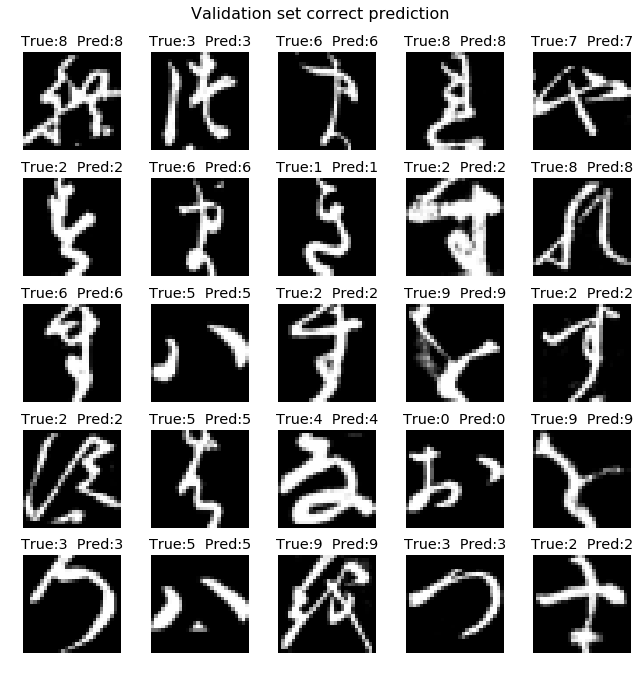

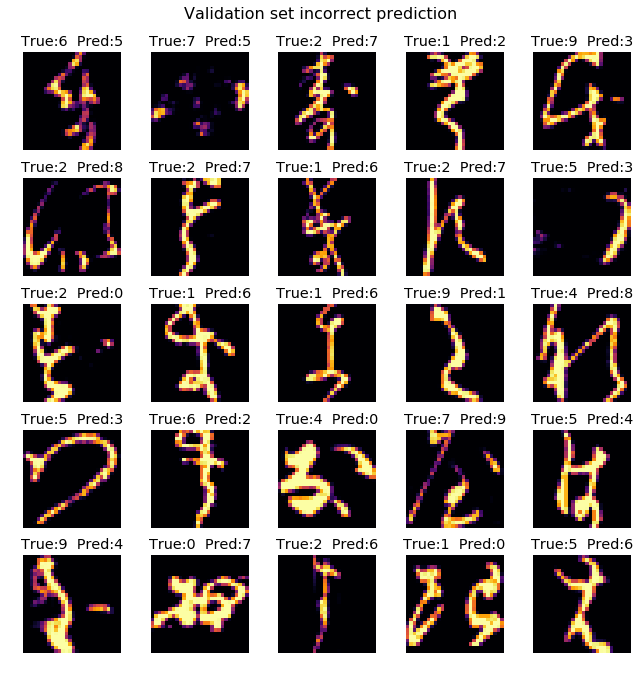

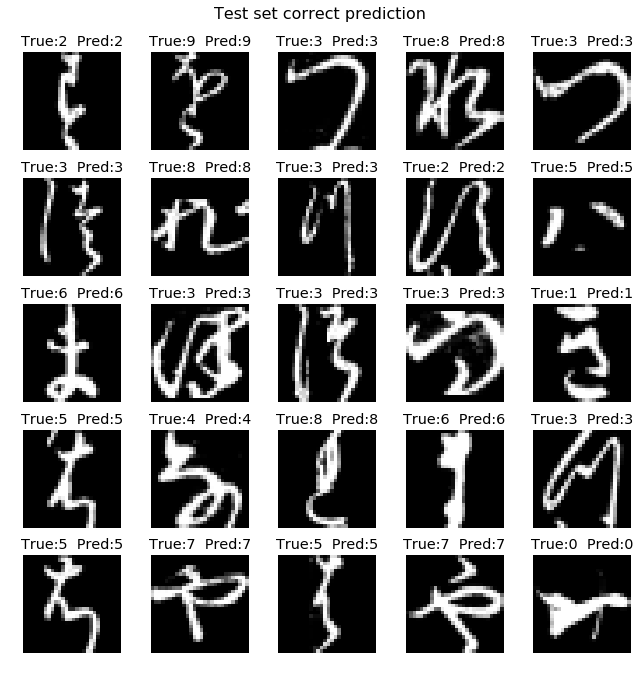

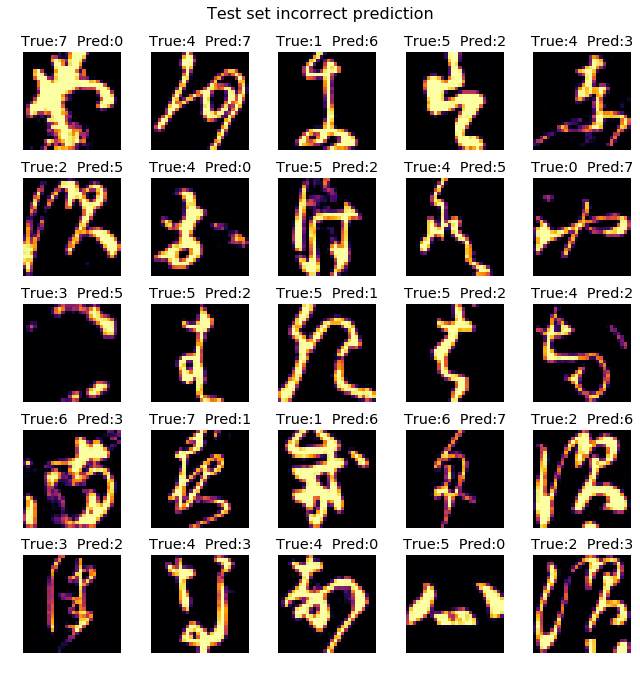

In [40]:
def plot_compare_prediction(data_index, img_array, predict_array, actual_array,
                            n_sample: int=25, cmap: str="gray", title: str=''):
    """
    Function to plot the prediction and actual images of given data
    """
    _dim = np.sqrt(n_sample)
    f, ax = plt.subplots(int(_dim), int(_dim), figsize=(9, 10))        
    for i, idx in enumerate(data_index[:n_sample]):
        ax[i//5, i%5].imshow(img_array[idx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("True:{}  Pred:{}".format(actual_array[idx],
                                                          predict_array[idx]))
    f.subplots_adjust(top=1.8)  # add this to handle tight_layout() method
    f.suptitle('%s' % title, fontsize=16)
    plt.tight_layout()
    plt.show()   

    
plot_compare_prediction(val_correct, X_val, y_val_pred, np.argmax(y_val, axis=1), cmap='gray',
           title='Validation set correct prediction')
plot_compare_prediction(val_incorrect, X_val, y_val_pred, np.argmax(y_val, axis=1), cmap='inferno',
           title='Validation set incorrect prediction')
plot_compare_prediction(test_correct, X_test, y_pred, np.argmax(y_test, axis=1), cmap='gray',
           title='Test set correct prediction')
plot_compare_prediction(test_incorrect, X_test, y_pred, np.argmax(y_test, axis=1), cmap='inferno',
           title='Test set incorrect prediction')

Ultimately, we can use [__shap__](https://github.com/slundberg/shap) to explain visually how the model predict the Kuzushiji characters.

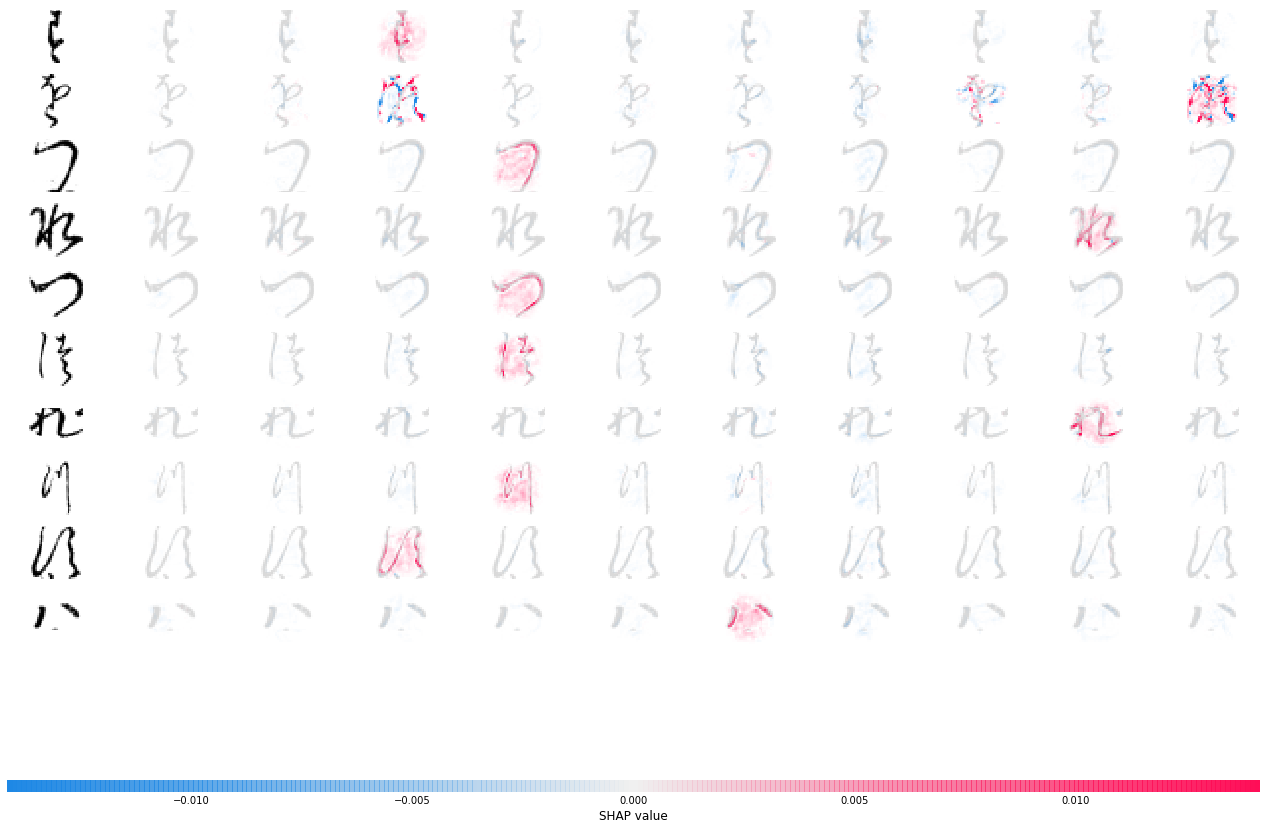

In [41]:
import shap

# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(X_test[0: 10])

# plot the feature attributions
shap.image_plot(shap_values, -X_test[0: 10])

The plot above explains how the outputs are derived for ten different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left, and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset) and the current model output. 

<br>

We can focus on the __red__ on how the model uses to figure out the output class. For example, the 3rd row, the output is を (or wo), the model focus on how the upper part is connected to lower part of the character and the empty space in between.

And that's it for this part 1 of __Kuzushiji__ MNIST classification!!! In this notebook, we have gone through how we can implement:

- __Dimensionality Reduction__ using various algorithms (i.e. PCA, t-SNE, LDA)
- Constructing __CNN__ model using Keras and how to manually create callbacks function
- Create performance report using plotly and visualize the correct and incorrect predicted images

